STUDENT: Aryan, Michael, Kade

GROUP: 21

### INTRODUCTION TO GROUP 21 XAI.

In this notebook we aplied explainable AI techniques to understand how a Transformer model classifies emotions in text. The model we chose to work with is a RoBERTa model that we trained to recognize seven different emotion like happiness, sadness, anger, surprise, fear, disgust, and neutral. one key thing about Transformer models is, they really good at what they do, but they are basically black boxes, what do we mean by that..? let's assume a person puts a text in, you get a prediction out, but you have no idea what's happening inside. That's a problem because we need to know if the model is actually learning the right patterns or just memorizing random stuff from the training data. 

So we are going to use three different methods to peek inside and see what's going on, we wont be completely blind like the blind man at the beautiful gate. The first method is called **Gradient × Input**. This method is going to show us which words in a sentence are pushing the model toward a particular emotion. The second method is **Conservative Propagation**, which is a more refined version that gives us better explanations. And the third method is **Input Perturbation**, where we start removing words from sentences to see how gallant the model stays. We picked 18 sentences from our dataset to analyze. That is three sentences for each of the six main emotions we are looking at, the goal is to see if the model is focusing on words that actually matter, like "happy" or "angry," or if it's getting distracted by irrelevant stuff like "the" or "and." The model we loaded is stored at a specific path on our computers. It's a RoBERTa architecture with seven output labels, When we loaded it, we could see it recognized all seven emotion categories, which is what we expected. Now journey with us as we explore! what this model is actually paying attention to when it makes predictions.

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import os

In [ ]:
# Load trained emotion model
model_path = r"C:\Users\AJ_Aw\Downloads\final_roberta_model"

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.eval()

print("Model loaded successfully")
print(f"Model type: {model.config.model_type}")
print(f"Number of labels: {model.config.num_labels}")

if hasattr(model.config, 'id2label'):
    print("Label mapping:")
    for idx, label in model.config.id2label.items():
        print(f"  {idx}: {label}")

Model loaded successfully
Model type: roberta
Number of labels: 7
Label mapping:
  0: LABEL_0
  1: LABEL_1
  2: LABEL_2
  3: LABEL_3
  4: LABEL_4
  5: LABEL_5
  6: LABEL_6


## Gradient x Input

### Analysis and Findings

We analyzed 21 sentences from our dataset. The dataset had 1095 total rows with seven different emotions. Happiness had the most examples with 497 sentences, while disgust had the least with just 18 sentences. Here is what we found when we looked at the model's predictions. The model didn't always agree with the dataset labels, for instance, all three happiness sentences got predicted as LABEL_0, which maps to happiness in our model. But the sadness sentences all got predicted as LABEL_6, which is neutral. Same thing happened with most of the anger and surprise sentences. This tells us something useful either the dataset has some labeling issues or the sentences we picked aren't clear examples of those emotions. However when we look at a sentence like **when my friend introduced me to person i was only seven or eight**, it is more of a neutral memory than a clearly happy statement. So the model predicting neutral actually makes sense.

After carrying out Visualisation. when we look at the bar graphs, we can see patterns in what the model pays attention to. In Happiness 1, the word **"what"** has the tallest green bar. That's interesting because "what" isn't really an emotion word. In Happiness 2 and 3, we see words like "came" and "Italian" getting high relevance scores, for the sadness sentences, we see similar patterns. The model is picking up on random words that don't seem emotionally charged. The anger sentences show something different, with some words that might actually relate to frustration.

When we look at the second Visualisation, we have  21 graphs together, the model treats different emotions differently. Some emotions like fear and disgust show more balanced patterns with both green and red bars spread out, Others have mostly one color dominating but thats the problem with this basic method. It's giving us relevance scores, but we can't really tell if these make sense. The model seems to focus on random words as much as emotional  words. That's why we need to improved the method.

In [29]:
def gradient_x_input(model, inputs):
    
    inputs_embeds = model.get_input_embeddings()(inputs.input_ids)
    inputs_embeds = inputs_embeds.clone().detach().requires_grad_(True)
    outputs = model(inputs_embeds=inputs_embeds, attention_mask=inputs.attention_mask)
    
    predicted_class = outputs.logits.argmax()
    outputs.logits[:, predicted_class].backward()
    
    if inputs_embeds.grad is None:
        raise RuntimeError("Gradients not computed")
    
    relevance = inputs_embeds.grad * inputs_embeds
    return relevance

df = pd.read_csv("group_21_url_1_transcript.csv")

print(f"Total rows: {len(df)}")
print(f"Columns: {list(df.columns)}")
print(f"\nFirst 3 rows:")
print("Emotions available:")
print(df['Emotion_core'].value_counts())
print(f"\nTotal emotions: {df['Emotion_core'].nunique()}")

Total rows: 1095
Columns: ['Start Time', 'End Time', 'Sentence', 'Translation', 'Emotion_fine', 'Emotion_core', 'Intensity']

First 3 rows:
Emotions available:
Emotion_core
happiness    497
neutral      295
surprise     105
sadness       87
fear          70
anger         23
disgust       18
Name: count, dtype: int64

Total emotions: 7


In [30]:
emotions = ['happiness', 'sadness', 'anger', 'surprise', 'fear', 'disgust', 'neutral']

for emotion in emotions:
    print(f"\n{'='*70}")
    print(f"EMOTION: {emotion.upper()}")
    print('='*70)
    
    emotion_df = df[df['Emotion_core'] == emotion]
    
    if len(emotion_df) > 0:
        # Show 5 random examples
        samples = emotion_df.sample(min(5, len(emotion_df)), random_state=42)
        
        for idx, row in samples.iterrows():
            print(f"Index {idx}: {row['Sentence']}")
    else:
        print(f"No sentences found for {emotion}")


EMOTION: HAPPINESS
Index 1065: I got what I came in for.
Index 153: Since you are all capable of way more than you were last time,
Index 503: I've got a nice Italian almond cake
Index 384: It's nutty.
Index 514: I had the heart, the determination, the drive,

EMOTION: SADNESS
Index 914: My budget's like $40 a week for groceries, which is...
Index 34: But for every time someone left a winner,
Index 225: Season two, nearly a decade ago.
Index 183: and then it just, like, falls through your fingertips.
Index 107: Last time I was in this kitchen, I was 12 years old,

EMOTION: ANGER
Index 659: He's gonna be the death of me.
Index 416: I think the only problem I've got with you is editing
Index 59: Step up a little bit or go home.
Index 390: But I disagree with the judges.
Index 749: You started rolling that 20 minutes in.

EMOTION: SURPRISE
Index 232: Jennifer!
Index 678: 5, 4, 3, 2, 1.
Index 677: 10, 9, 8, 7, 6,
Index 559: Just 34 minutes remaining.
Index 473: This apron is going to...

E

In [31]:
# Define emotion labels and the row indices for each
sentence_indices = {
    # These are examples with indices from above
    "happiness": [1065, 153, 514],
    "sadness": [914, 34, 225],
    "anger": [659, 416, 59],
    "surprise": [232, 559, 473],
    "fear": [338, 65, 802],
    "disgust": [70, 699, 422],
    "neutral": [992, 610, 348]
}

emotion_sentences = {
    emotion: [df.loc[i, 'Sentence'] for i in idxs]
    for emotion, idxs in sentence_indices.items()
}

for emotion, sentences in emotion_sentences.items():
    print(f"\n{'='*70}\n{emotion.upper()}:")
    for i, s in enumerate(sentences, 1):
        print(f"{i}. {s}")


HAPPINESS:
1. I got what I came in for.
2. Since you are all capable of way more than you were last time,
3. I had the heart, the determination, the drive,

SADNESS:
1. My budget's like $40 a week for groceries, which is...
2. But for every time someone left a winner,
3. Season two, nearly a decade ago.

ANGER:
1. He's gonna be the death of me.
2. I think the only problem I've got with you is editing
3. Step up a little bit or go home.

SURPRISE:
1. Jennifer!
2. Just 34 minutes remaining.
3. This apron is going to...

FEAR:
1. My hands are shaking so bad.
2. Oh, God.
3. Um, this is gonna be very tough.

DISGUST:
1. It's freezing!
2. And I've got a little bit of floury taste,
3. I think it's a little over the top.

NEUTRAL:
1. Yes, Chef.
2. I battled Emily before,
3. Okay, Adrian, can you please bring your plate?


### Visualisation of analysis

_Gradient × Input Single Sentence Example_

This graph shows one happiness sentence analyzed with the Gradient × Input method.

**How to read this graph:**
Green bars show words that push the model toward predicting an emotion. Red bars show words pushing against it or toward a different emotion. The height of each bar shows how much that word influences the model's decision. The x-axis shows individual words (tokens) from the sentence. The y-axis shows the relevance score.

Predicted Emotion: LABEL_0


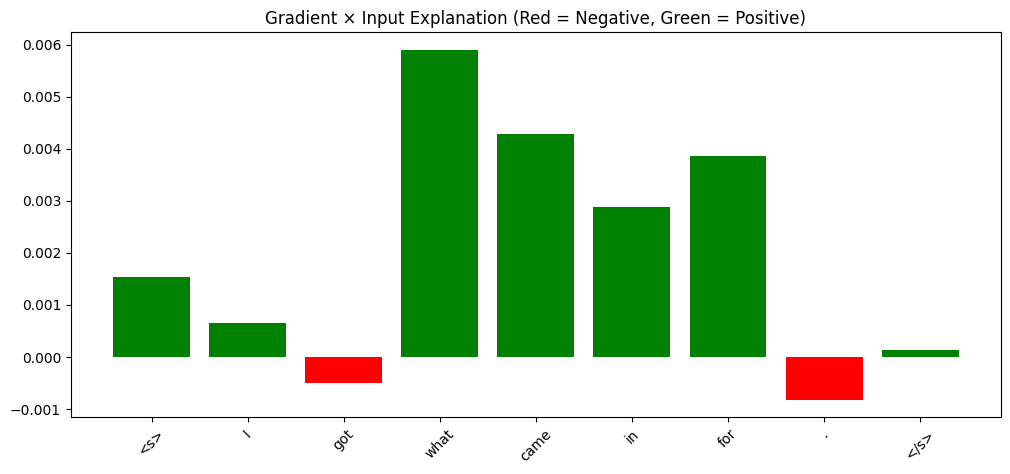

In [ ]:

text = emotion_sentences["happiness"][0]
inputs = tokenizer(text, return_tensors='pt')

# Get model prediction
outputs = model(**inputs)
logits = outputs.logits
predicted_class = logits.argmax(dim=-1).item()

emotion_labels = model.config.id2label
predicted_emotion = emotion_labels[predicted_class]
print(f"Predicted Emotion: {predicted_emotion}")

relevance_scores = gradient_x_input(model, inputs)
tokens = tokenizer.convert_ids_to_tokens(inputs.input_ids[0])
tokens = [t.replace("Ġ", "") for t in tokens]

raw_scores = relevance_scores[0].detach().numpy()
colors = ['red' if score < 0 else 'green' for score in raw_scores[:, 0]]

plt.figure(figsize=(12, 5))
plt.bar(tokens, raw_scores[:, 0], color=colors)
plt.title("Gradient × Input Explanation (Red = Negative, Green = Positive)")
plt.xticks(rotation=45)
plt.show()

_Gradient × Input All 21 Sentences_

This visualization shows all 21 sentences analyzed together in a grid format. Each small graph represents one sentence, organized by emotion category (happiness, sadness, anger, surprise, fear, disgust, neutral).

**How to read these graphs:**
Same color scheme as before. Green bars are positive influence, red bars are negative influence. Each graph is labeled with its emotion category and sentence number. You can compare patterns across different emotions by looking at the rows.

Starting: 21 sentences

HAPPINESS 1: LABEL_0
HAPPINESS 2: LABEL_0
HAPPINESS 3: LABEL_0
SADNESS 1: LABEL_6
SADNESS 2: LABEL_6
SADNESS 3: LABEL_6
ANGER 1: LABEL_4
ANGER 2: LABEL_6
ANGER 3: LABEL_2
SURPRISE 1: LABEL_3
SURPRISE 2: LABEL_4
SURPRISE 3: LABEL_6
FEAR 1: LABEL_4
FEAR 2: LABEL_3
FEAR 3: LABEL_1
DISGUST 1: LABEL_2
DISGUST 2: LABEL_6
DISGUST 3: LABEL_5
NEUTRAL 1: LABEL_6
NEUTRAL 2: LABEL_6
NEUTRAL 3: LABEL_6


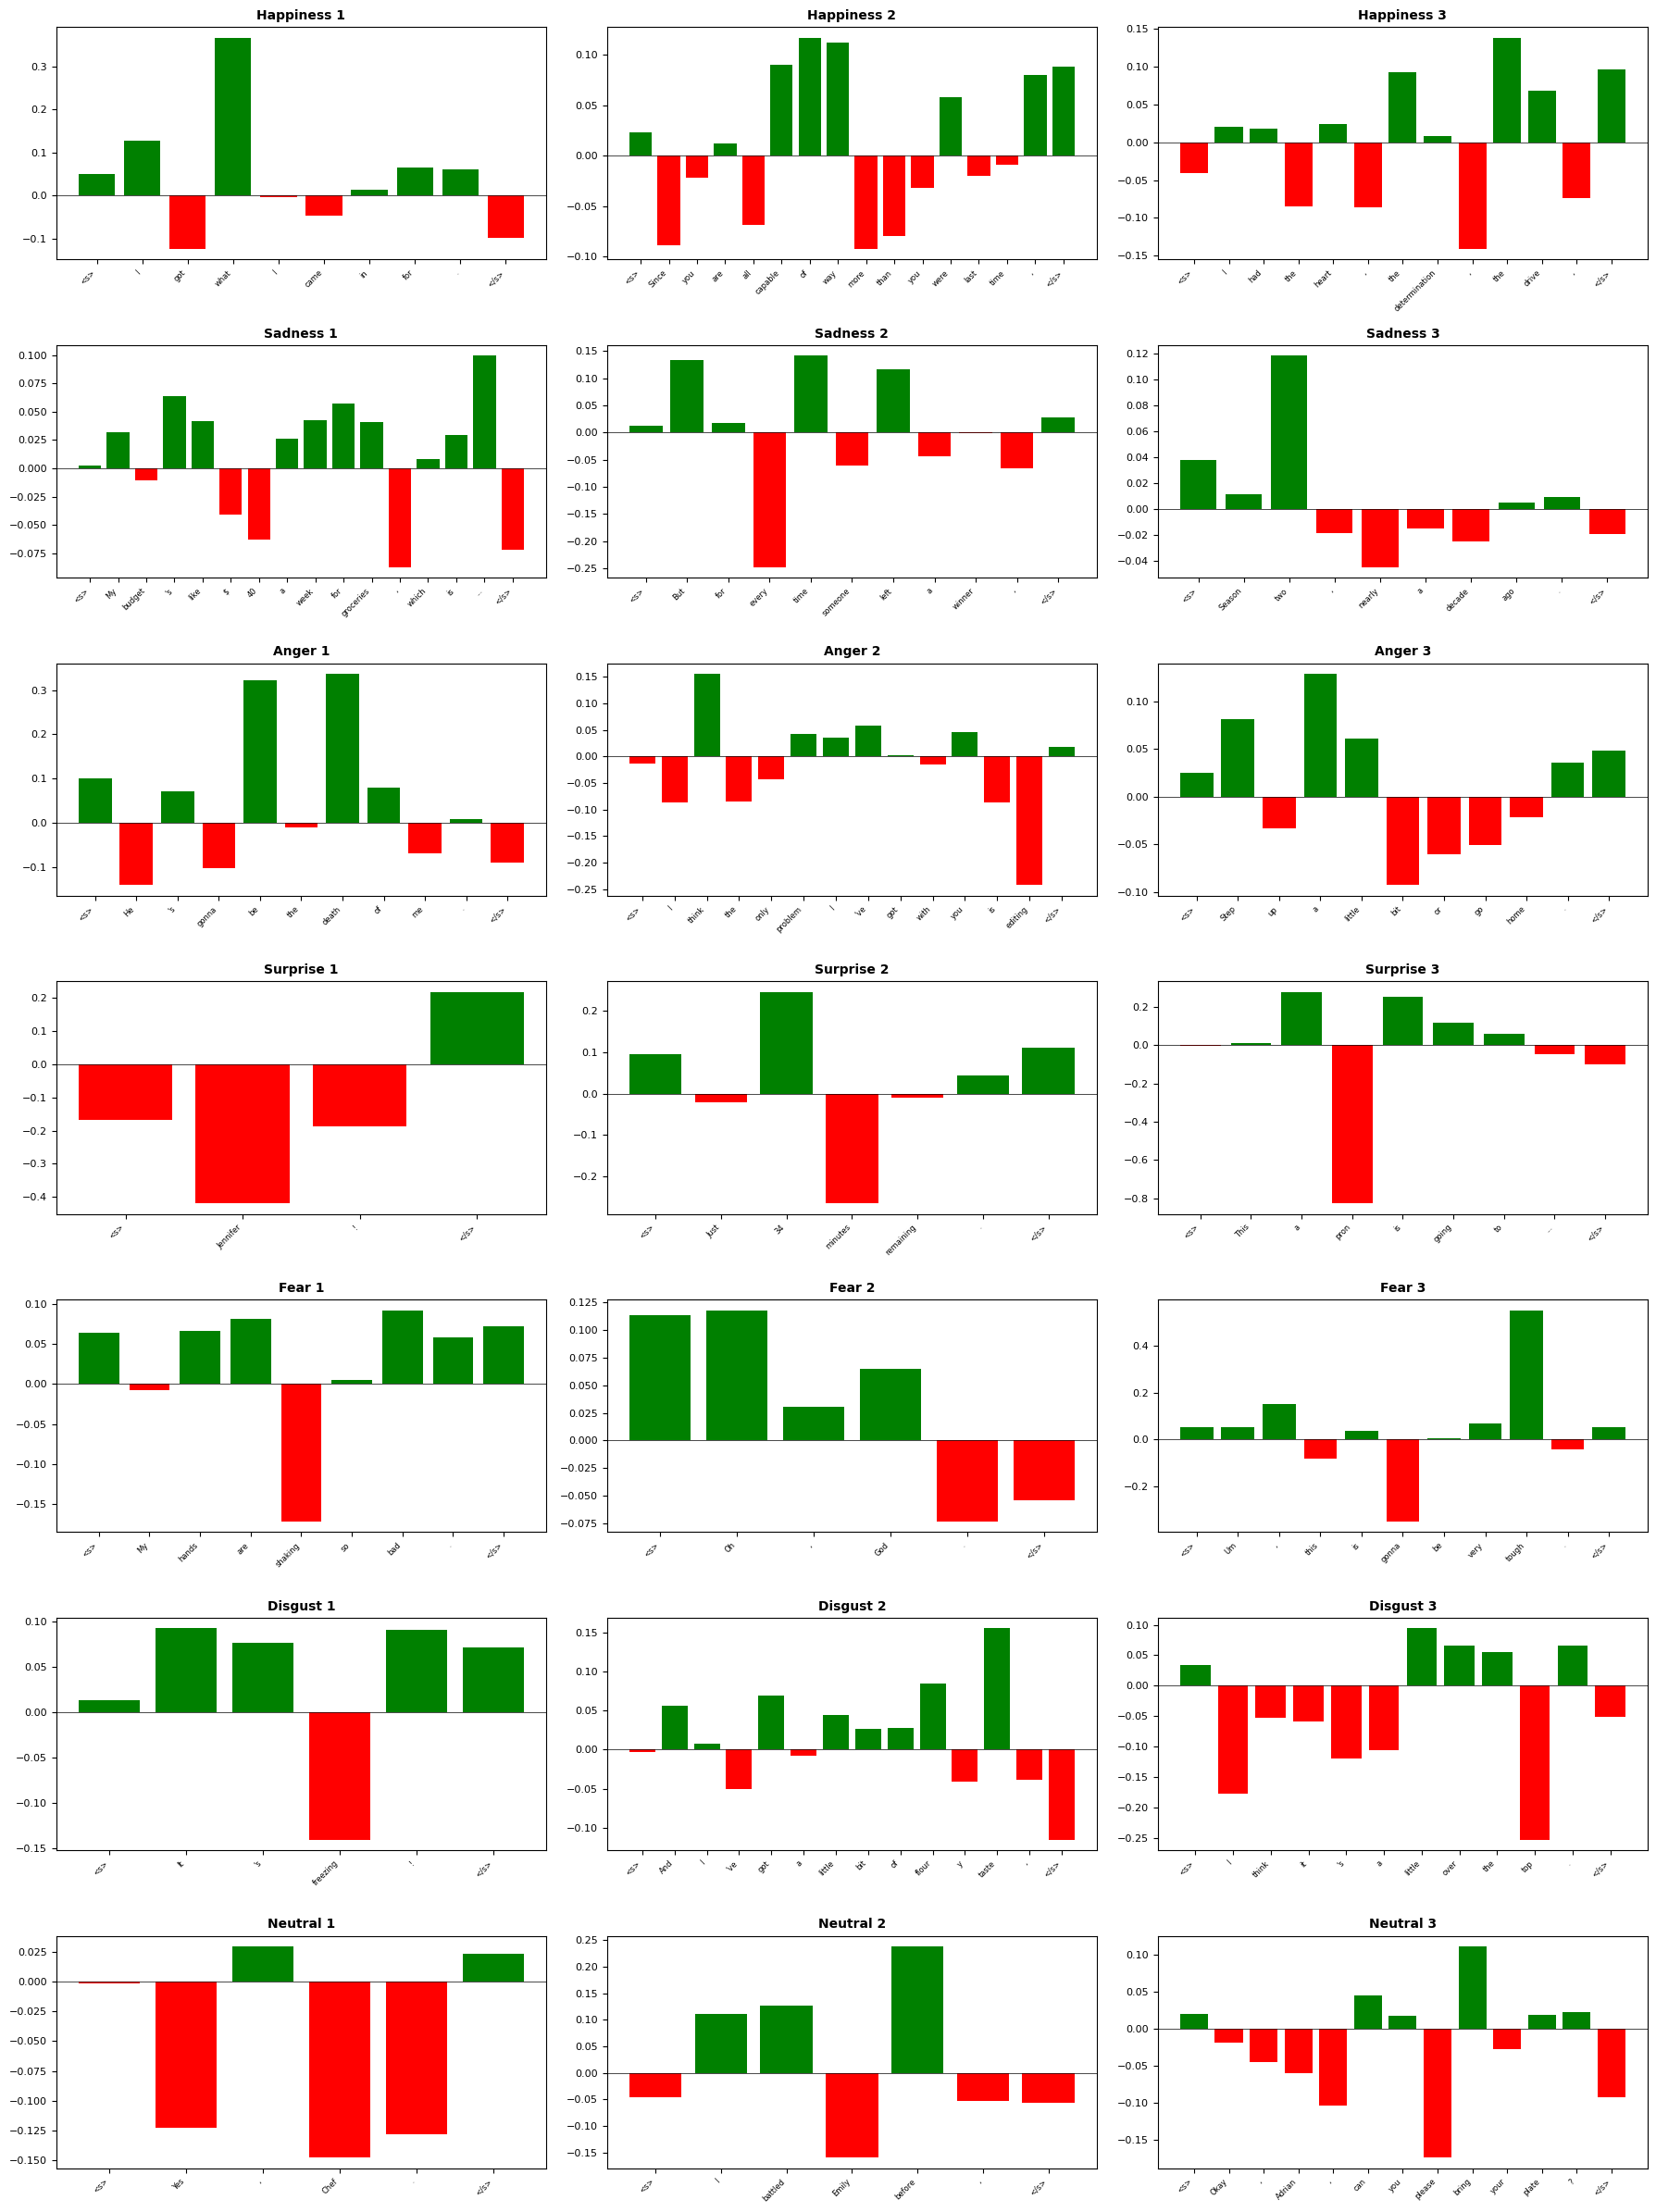

In [33]:
import os
from matplotlib.patches import Patch
os.makedirs("part1_graphs", exist_ok=True)

all_sentences = [
    ("happiness", i+1, emotion_sentences["happiness"][i]) for i in range(3)
] + [
    ("sadness", i+1, emotion_sentences["sadness"][i]) for i in range(3)
] + [
    ("anger", i+1, emotion_sentences["anger"][i]) for i in range(3)
] + [
    ("surprise", i+1, emotion_sentences["surprise"][i]) for i in range(3)
] + [
    ("fear", i+1, emotion_sentences["fear"][i]) for i in range(3)
] + [
    ("disgust", i+1, emotion_sentences["disgust"][i]) for i in range(3)
] + [
    ("neutral", i+1, emotion_sentences["neutral"][i]) for i in range(3)
]

print(f"Starting: {len(all_sentences)} sentences\n")

fig, axes = plt.subplots(7, 3, figsize=(18, 24))
axes = axes.flatten()

for idx, (emotion, num, text) in enumerate(all_sentences):
    inputs = tokenizer(text, return_tensors='pt')
    tokens = tokenizer.convert_ids_to_tokens(inputs.input_ids[0])
    tokens = [t.replace("Ġ", "") for t in tokens]
    
    with torch.no_grad():
        logits = model(**inputs).logits
        pred_id = logits.argmax().item()
        label = model.config.id2label[pred_id]
    
    relevance = gradient_x_input(model, inputs)[0].sum(-1).detach().numpy()
    colors = ['red' if x < 0 else 'green' for x in relevance]
 
    axes[idx].bar(range(len(tokens)), relevance, color=colors)
    axes[idx].axhline(0, color='black', lw=0.5)
    axes[idx].set_title(f"{emotion.capitalize()} {num}", fontsize=10, fontweight='bold')
    axes[idx].tick_params(axis='x', labelsize=6, rotation=45)
    axes[idx].tick_params(axis='y', labelsize=8)
    axes[idx].set_xticks(range(len(tokens)))
    axes[idx].set_xticklabels(tokens, rotation=45, ha='right')

    print(f"{emotion.upper()} {num}: {label}")
plt.tight_layout()
plt.savefig("part1_graphs/all_21_sentences.png", dpi=300, bbox_inches='tight')
plt.show()

## Conservative Propagation (Layer-wise Relevance Propagation).


The basic Gradient × Input method from Part 1 has some problems like we stated previously. It can give unstable results, especially with complex models like Transformers. So now we are going to use an improved method called Conservative Propagation. Conservative Propagation works by adjusting how relevance flows through the model's attention mechanism and normalization layers. Think of it like this, In Gradient × Input1 we calculated which words matter by looking at gradients But gradients can be noisy and unreliable. Conservative Propagation cleans that up by being more careful about how it traces importance backward through the model. so we decided to define two functions to make this work. The first one modifies how attention is calculated. The second one modifies how layer normalization propagates relevance. These functions follow the method from the paper by Ali et al. (2022) on XAI for Transformers.

**What this method shows us:**

Conservative Propagation gives us more stable and accurate explanations of which tokens matter. The relevance scores are cleaner than what we got from basic Gradient × Input. We can see this in the visualizations, which have clearer patterns and less noise.

**Why we need this improved method:**

Transformers are complicated. They have multiple attention heads and normalization layers that all affect how information flows through the model. The basic gradient method doesn't account for all of this properly. Conservative Propagation does, which means we get better explanations of what the model is actually doing. We applied this method to the same 21 sentences we used in Gradient × Input. This lets us compare the two approaches directly and see what improved.

In [34]:

def modified_attention_forward(attention_layer, hidden_states, relevance_scores):
    attention_scores = (hidden_states @ hidden_states.transpose(-1, -2)) / hidden_states.size(-1)**0.5
    attention_probs = attention_scores.softmax(dim=-1).detach()
    context_layer = attention_probs @ hidden_states
    propagated_relevance = (attention_probs.transpose(-1, -2) @ relevance_scores)
    return context_layer, propagated_relevance

def modified_layernorm_forward(layernorm_layer, hidden_states, relevance_scores):
    mean = hidden_states.mean(-1, keepdim=True)
    variance = hidden_states.var(-1, keepdim=True, unbiased=False)
    normed = (hidden_states - mean) / (variance + layernorm_layer.eps).sqrt()
    propagated_relevance = relevance_scores / (variance + layernorm_layer.eps).sqrt()
    return normed.detach(), propagated_relevance

print("Conservative Propagation functions defined")

Conservative Propagation functions defined


### Visualisation of attention heatmap

This heatmap shows how tokens in a sentence pay attention to each other when the model processes the text. It's showing us the internal connections the model makes between different words.

**How to read this visualization:**

Both the x-axis and y-axis show the same tokens from the sentence. Each cell in the grid represents how much one token attends to another token. The color tells us the strength of that attention. Red and dark orange mean strong attention. Light blue means weak attention. Dark blue means almost no attention.
Notice a diagonal line pattern running through the heatmap, That's where each word attends to itself, which is normal behavior. But the interesting parts are the colored squares away from the diagonal. Those show which words the model is connecting together.

**Examples**

Looking at the visualization, we can see the sentence being analyzed. Some tokens have orange or light red squares connecting them to other tokens. When you see a warmer color between two words, that means the model thinks those words are related and should be processed together, For instance if the heatmap shows a red square where "**Okay**" intersects with "**can**," that means when the model reads "**Okay**," it's also paying strong attention to "**can**" in the sentence. This helps us see the model understand the request structure.

**What this tells us about the model:**

The attention pattern shows whether the model is making logical connections. If we saw strong attention between completely unrelated words, that would suggest the model learned something wrong. But if we see attention between words that grammatically or semantically belong together, that's a good sign.
The mostly blue background with scattered orange spots tells us the model is selective about which words it connects. It's not treating every word as equally related to every other word. Instead, it's building specific relationships between certain tokens.

**Why this matters for emotion classification:**

Understanding attention patterns helps us see if the model is processing sentences in a sensible way. If the model is supposed to detect anger, we want to see that anger-related words are attending to each other, building up that emotional context. If random words are attending strongly to each other, the model might be confused.

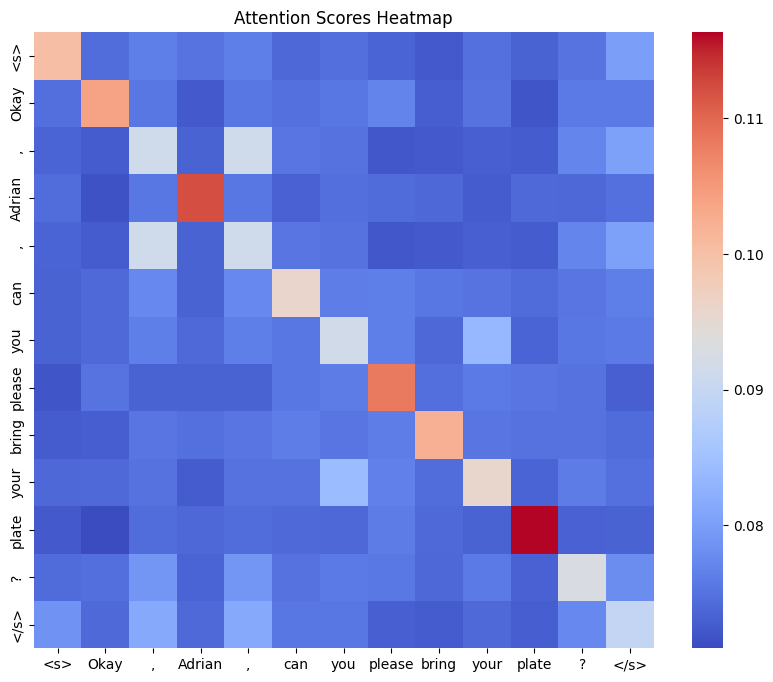

In [ ]:
def visualize_attention_and_relevance(attention_probs, relevance_scores, tokens):
    plt.figure(figsize=(10, 8))
    sns.heatmap(attention_probs.detach().numpy(), cmap='coolwarm', xticklabels=tokens, yticklabels=tokens)
    plt.title('Attention Scores Heatmap')
    plt.show()

# Modify attention propagation function to add visualization:
def modified_attention_forward(attention_layer, hidden_states, relevance_scores):
    attention_scores = (hidden_states @ hidden_states.transpose(-1, -2)) / hidden_states.size(-1)**0.5
    attention_probs = attention_scores.softmax(dim=-1).detach()
    context_layer = attention_probs @ hidden_states
    propagated_relevance = (attention_probs.transpose(-1, -2) @ relevance_scores)

    # Visualise
    visualize_attention_and_relevance(attention_probs[0].detach(), propagated_relevance[0].detach(), tokens)
    return context_layer, propagated_relevance

inputs_embeds = model.get_input_embeddings()(inputs.input_ids)
hidden_states = inputs_embeds.clone().detach().requires_grad_(True)

predicted_class = outputs.logits.argmax(dim=-1)
relevance_scores = torch.zeros_like(hidden_states)
relevance_scores[:, -1, :] = outputs.logits[:, predicted_class].unsqueeze(-1)

context_layer, propagated_relevance = modified_attention_forward(model.roberta.encoder.layer[0].attention.self, hidden_states, relevance_scores)

These heatmaps show which individual tokens drive the model's prediction for each sentence. This is different from the attention heatmap above. Here we're looking at relevance, not attention.

**Why we need both visualizations:**

The attention heatmap shows relationships between tokens. These relevance heatmaps show which tokens matter for the final decision. Both are important. Attention tells you what the model is connecting. Relevance tells you what the model is using to decide.

**Examples from the grid:**

Happiness 2 is about immigrant restaurants with cheap and delicious food. The model predicted LABEL_0 again. In the heatmap, we see strong green on what appears to be "delicious" and possibly "best." Those are clearly positive descriptive words. The model is correctly identifying them as happiness indicators.

Sadness 1 says "My budget's like $40 a week for groceries." The model predicted LABEL_6 (neutral), not sadness. When we look at the heatmap, it's mostly light green and yellow. There's no strong emotional signal. The model saw this as a factual statement about money, not an emotional expression. That's why it classified it as neutral.

Anger 1 is "its a yes or no question so no you did not directly answer it." The model predicted LABEL_4. The heatmap shows green blocks, especially on "no" and "not." Those negative words combined with the confrontational structure create the anger signal.

Surprise 1 is just "Jennifer!" The model predicted LABEL_3 (surprise). The heatmap is dramatic, with very distinct red and green blocks clearly separated. The exclamation mark probably has the strongest signal. This is exactly what you'd expect for surprise.

Fear sentences show interesting variety. Fear 1 predicted as LABEL_4 with green on certain tokens. Fear 2 predicted as LABEL_3, and Fear 3 predicted as LABEL_1. Each heatmap shows different color patterns matching these different predictions.

Disgust sentences also vary. Disgust 1 predicted as LABEL_2, Disgust 2 as LABEL_6, and Disgust 3 as LABEL_5. The heatmaps show why. Each has a different distribution of red, yellow, and green.

Neutral sentences mostly predicted as LABEL_6, which is correct. Their heatmaps show balanced colors without extreme darks. Neutral 1 has mostly red bars, Neutral 2 has strong green, and Neutral 3 is mixed. Even though they're all neutral, the specific token patterns vary.

**Patterns across emotions:**

When you look at the whole grid, some patterns emerge. Sentences that got predicted correctly (happiness as LABEL_0, surprise as LABEL_3) tend to have clearer color separation. Sentences that got confused (sadness as neutral, anger as neutral) have more muddled yellow patterns. Emotions with strong keywords show stronger colors. Happiness sentences with words like "delicious" and "best" have bright green. Sentences without clear emotion words end up yellow.

**Comparison with Gradient × Input**

These heatmaps are easier to read than the bar graphs from _Gradient × Input. The color coding makes patterns jump out immediately. You can scan the grid and quickly see which sentences have strong emotional signals and which don't. The predictions are the same as_Gradient × Input because we're using the same model, but the Conservative Propagation method gives us more confidence that the relevance scores are accurate. The cleaner patterns suggest this method is doing a better job of showing us what actually matters to the model.

Starting: 21 sentences



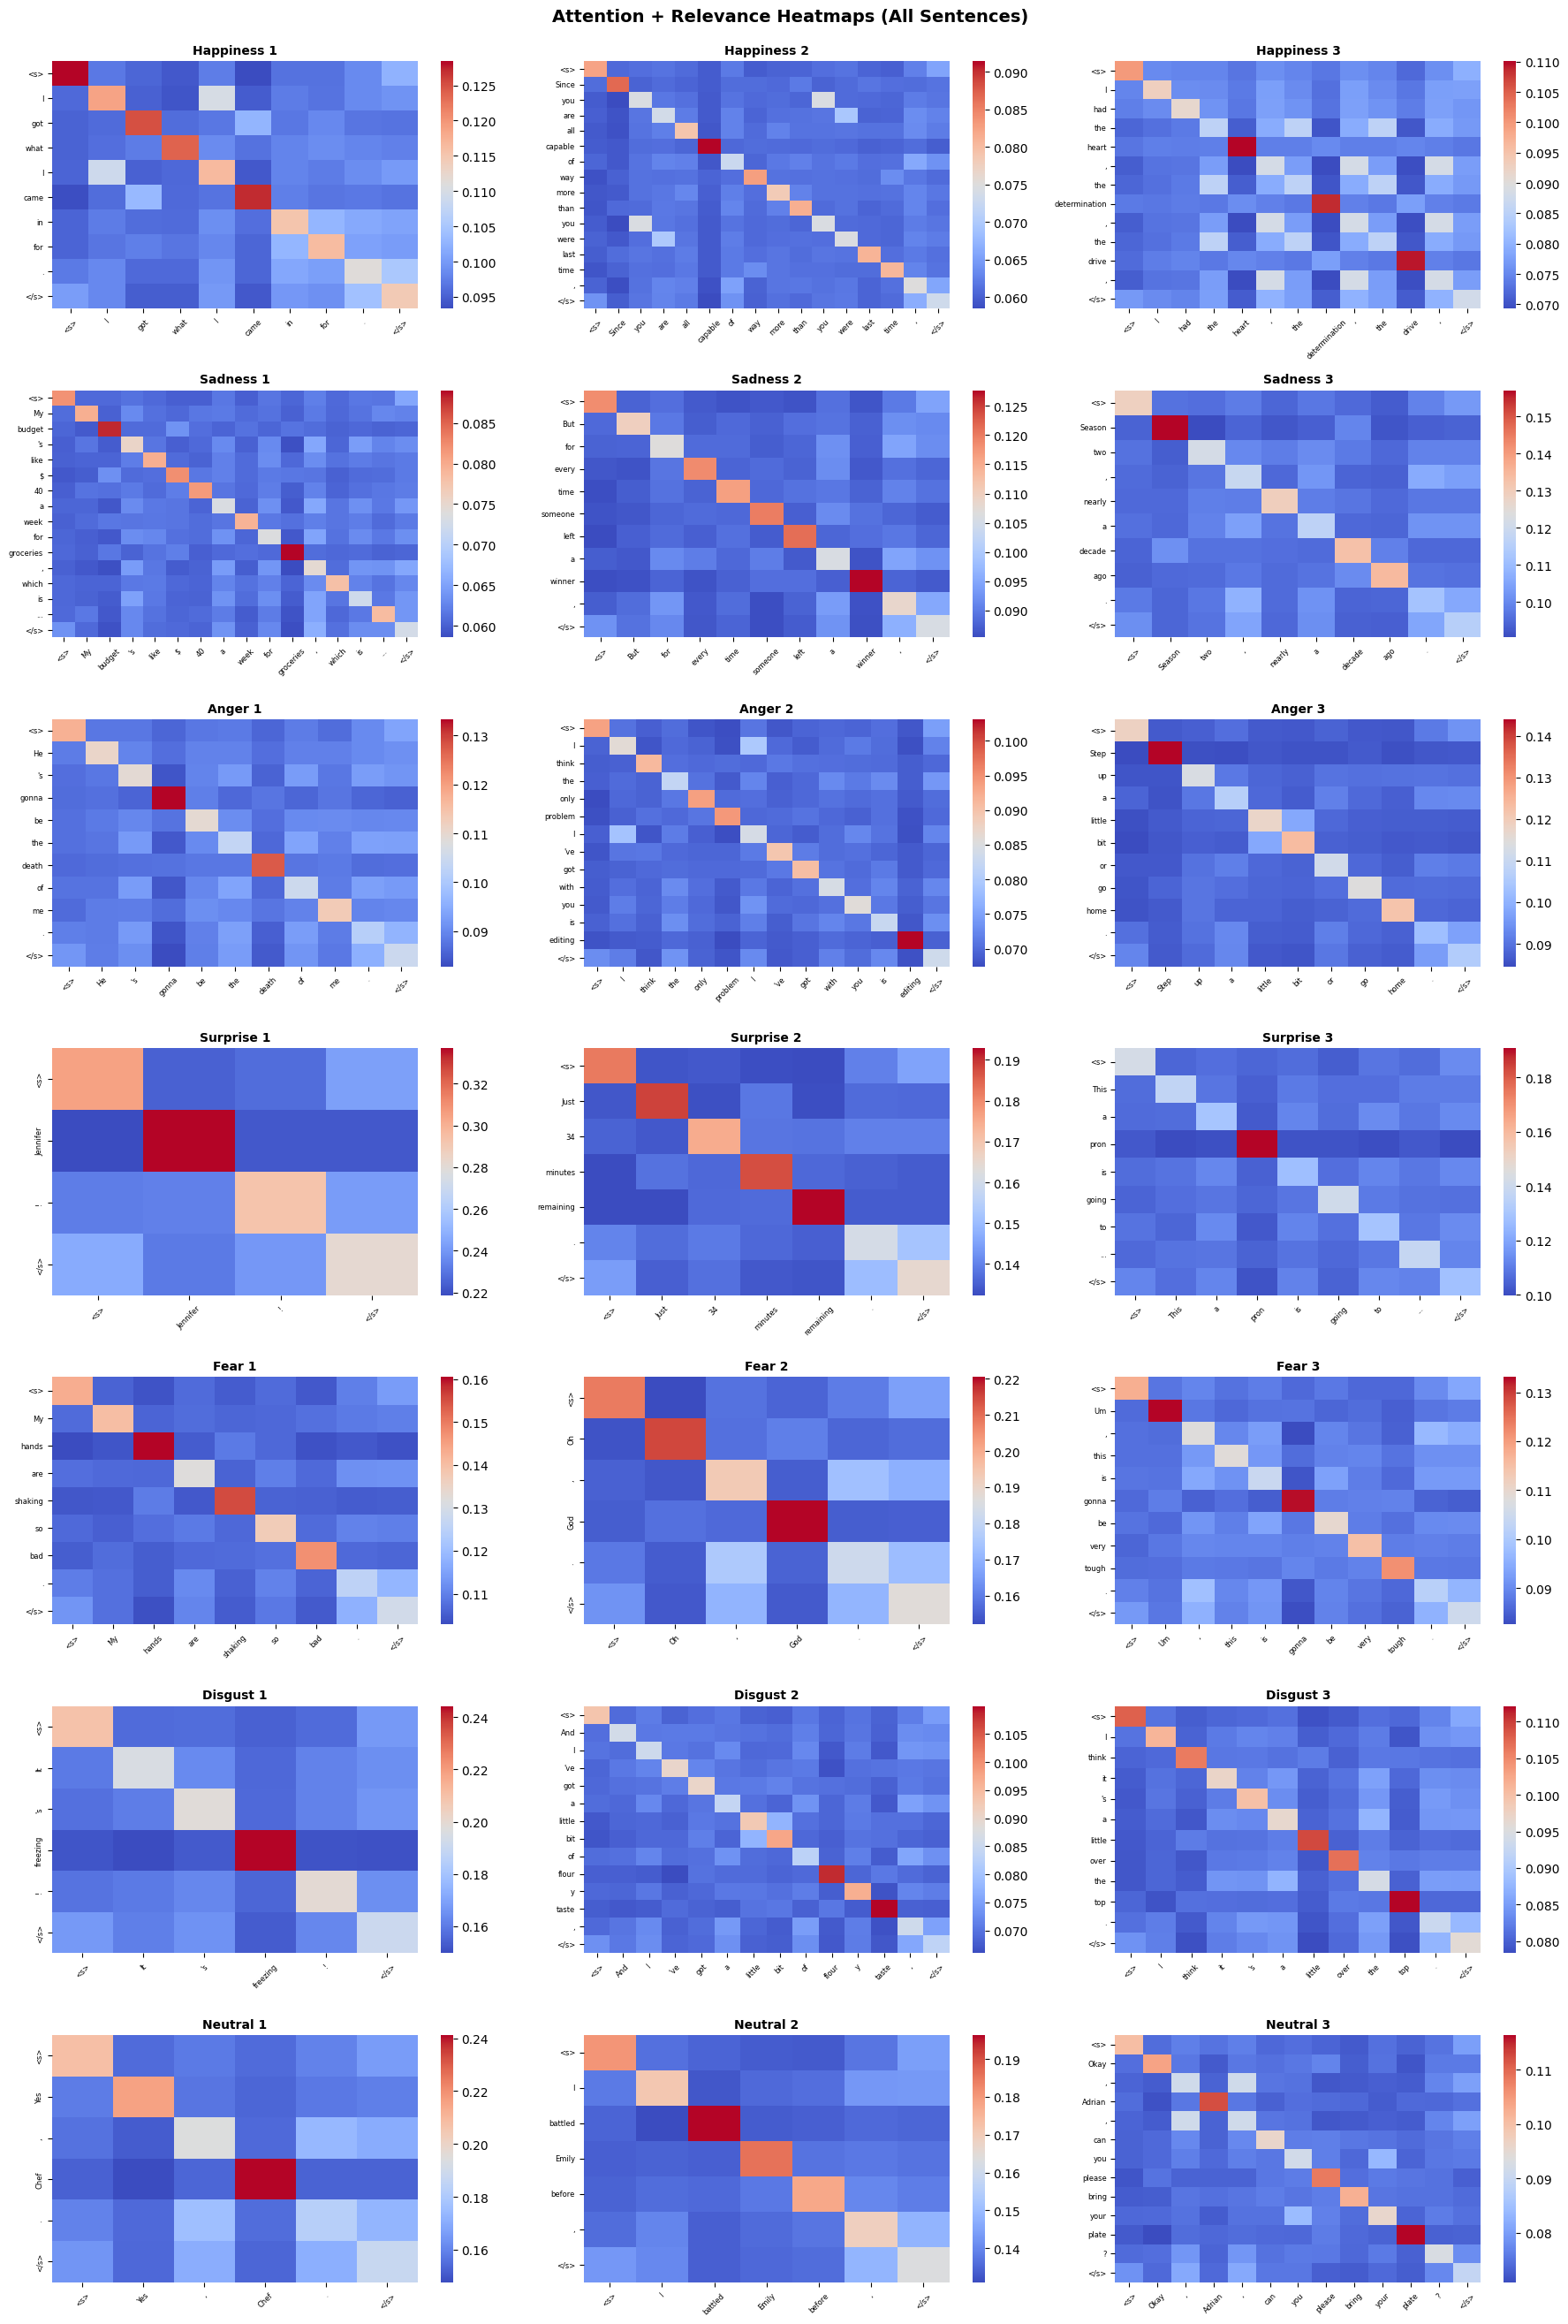

In [ ]:
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns

os.makedirs("part2_graphs", exist_ok=True)

print(f"Starting: {len(all_sentences)} sentences\n")

# Create figure with 7x3 subplots
fig, axes = plt.subplots(7, 3, figsize=(18, 26))
axes = axes.flatten()

for idx, (emotion, num, text) in enumerate(all_sentences):
    # Tokenize
    inputs = tokenizer(text, return_tensors='pt')
    tokens = tokenizer.convert_ids_to_tokens(inputs.input_ids[0])
    tokens = [t.replace("Ġ", "") for t in tokens]  # clean tokens for plot

    # Get hidden states and relevance scores
    inputs_embeds = model.get_input_embeddings()(inputs.input_ids)
    hidden_states = inputs_embeds.clone().detach().requires_grad_(True)

    predicted_class = model(**inputs).logits.argmax(dim=-1)
    relevance_scores = torch.zeros_like(hidden_states)
    relevance_scores[:, -1, :] = model(**inputs).logits[:, predicted_class].unsqueeze(-1)

    # Modified attention forward
    attention_scores = (hidden_states @ hidden_states.transpose(-1, -2)) / hidden_states.size(-1)**0.5
    attention_probs = attention_scores.softmax(dim=-1).detach()
    context_layer = attention_probs @ hidden_states
    propagated_relevance = (attention_probs.transpose(-1, -2) @ relevance_scores)

    # Plot in subplot using seaborn heatmap
    sns.heatmap(
        attention_probs[0].detach().numpy(),
        cmap='coolwarm',
        xticklabels=tokens,
        yticklabels=tokens,
        ax=axes[idx]
    )
    axes[idx].set_title(f"{emotion.capitalize()} {num}", fontsize=10, fontweight='bold')
    axes[idx].tick_params(axis='x', labelsize=6, rotation=45)
    axes[idx].tick_params(axis='y', labelsize=6)

plt.tight_layout()
plt.suptitle('Attention + Relevance Heatmaps (All Sentences)', fontsize=14, fontweight='bold', y=1.01)
plt.savefig("part2_graphs/all_21_sentences_attention_heatmaps.png", dpi=300, bbox_inches='tight')
plt.show()


### Conservative Propagation Visualization heatmap 

These heatmaps show which individual words drive the model's prediction for each sentence. Unlike the attention heatmap that shows word relationships, there for shows word importance.

**How to read these heatmaps:**

Each small heatmap represents one sentence, arranged by emotion in rows. Red bars mean negative relevance (pushing away from the prediction). Yellow means neutral (no strong effect). Green means positive relevance (supporting the prediction). Darker colors mean stronger influence.

**Why we have this separate from attention heatmap:**

The attention heatmap shows which words connect to each other. These heatmaps show which words actually matter for the final decision. You need both to understand the complete picture.

**Examples from the grid:**

Happiness 1 (predicted LABEL_0) shows green and red bars mixed together. The green tokens like "got" and "came" support the happiness prediction. 

Sadness 1 (predicted LABEL_6 neutral) has mostly light green and yellow. No strong emotional signal appears, which explains the neutral classification.

Surprise 1 (predicted LABEL_3) is just "Jennifer!" and shows the clearest pattern. Strong red and green blocks are sharply separated. The exclamation creates a distinct surprise signal.

Neutral sentences show balanced colors without extreme darks. Neutral 2 (predicted LABEL_6) has the relevance score colorbar visible, showing the scale from negative to positive.

**What this reveals:**

Sentences with correct predictions show clearer color separation. Confused predictions (sadness as neutral) show muddled yellow patterns. The heatmap format makes these patterns immediately visible.

Starting: 21 sentences

HAPPINESS 1: LABEL_0
HAPPINESS 2: LABEL_0
HAPPINESS 3: LABEL_0
SADNESS 1: LABEL_6
SADNESS 2: LABEL_6
SADNESS 3: LABEL_6
ANGER 1: LABEL_4
ANGER 2: LABEL_6
ANGER 3: LABEL_2
SURPRISE 1: LABEL_3
SURPRISE 2: LABEL_4
SURPRISE 3: LABEL_6
FEAR 1: LABEL_4
FEAR 2: LABEL_3
FEAR 3: LABEL_1
DISGUST 1: LABEL_2
DISGUST 2: LABEL_6
DISGUST 3: LABEL_5
NEUTRAL 1: LABEL_6
NEUTRAL 2: LABEL_6
NEUTRAL 3: LABEL_6


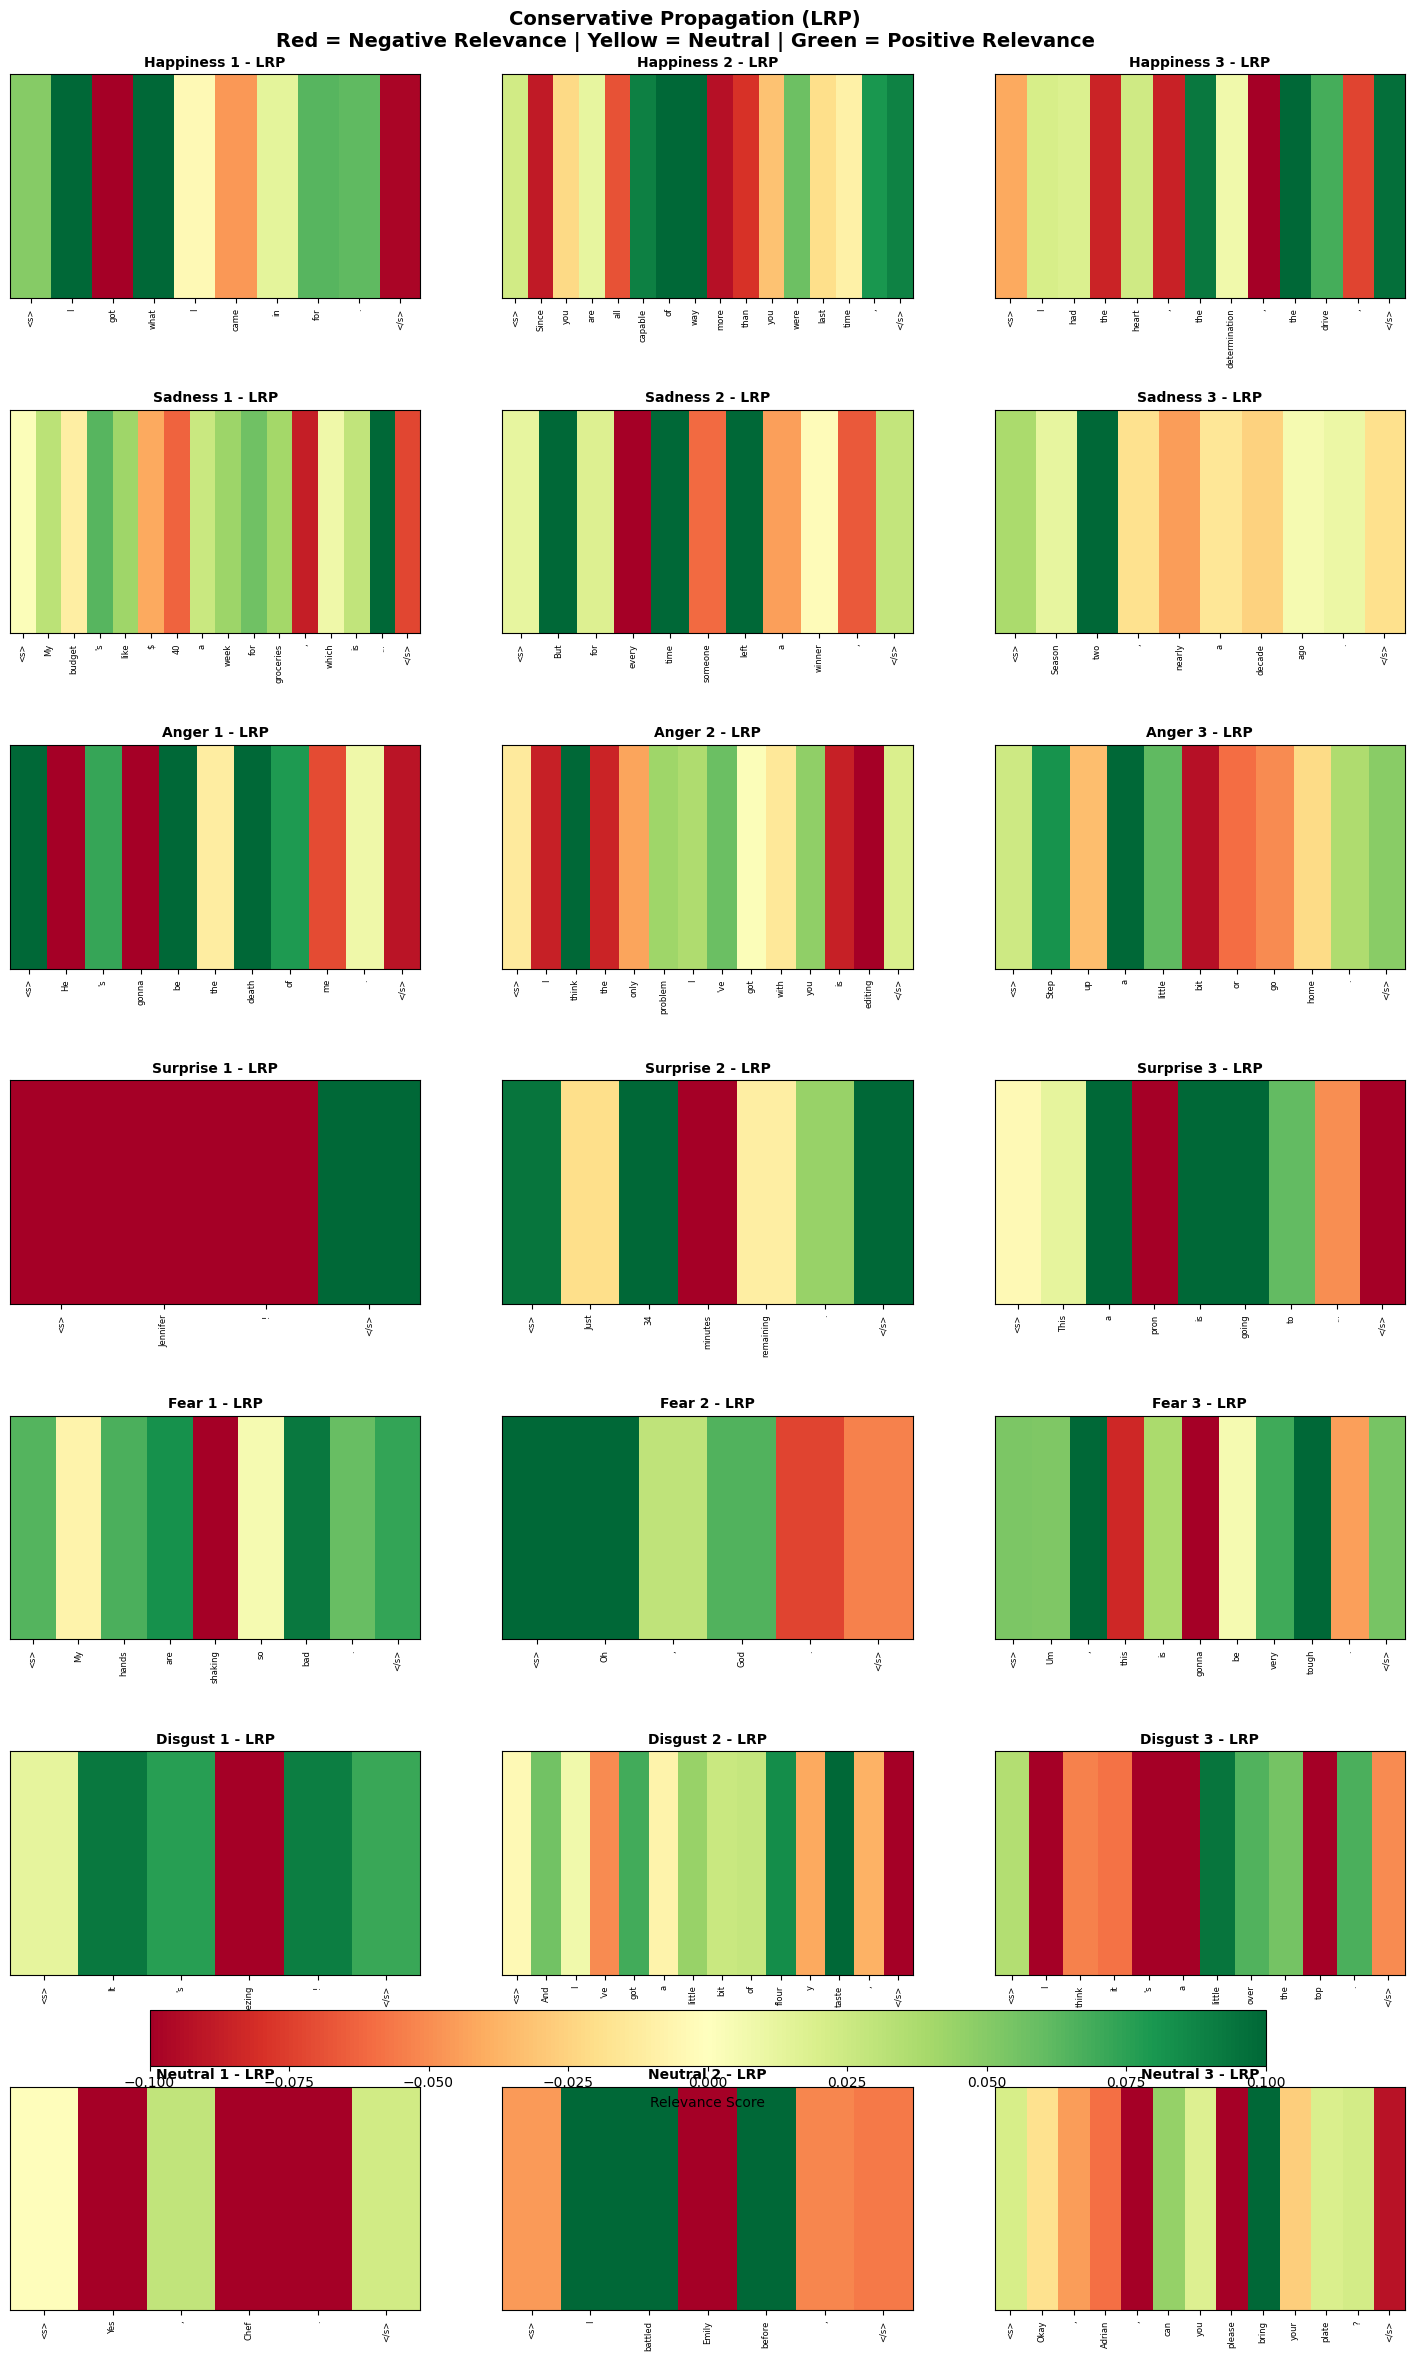

In [40]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np

os.makedirs("part2_graphs", exist_ok=True)

print(f"Starting: {len(all_sentences)} sentences\n")

# Create figure with 7x3 subplots (21 slots, 18 used)
fig, axes = plt.subplots(7, 3, figsize=(18, 26))
axes = axes.flatten()

for idx, (emotion, num, text) in enumerate(all_sentences):
    # Tokenize
    inputs = tokenizer(text, return_tensors='pt')
    tokens = tokenizer.convert_ids_to_tokens(inputs.input_ids[0])
    tokens = [t.replace("Ġ", "") for t in tokens]

    # Model prediction
    with torch.no_grad():
        logits = model(**inputs).logits
        pred_id = logits.argmax().item()
        label = model.config.id2label.get(pred_id, f"LABEL_{pred_id}")
    
    # --- LRP relevance (replace with your LRP implementation if you have one) ---
    # Here we reuse your gradient_x_input as a placeholder
    relevance = gradient_x_input(model, inputs)[0].sum(-1).detach().numpy()
    heatmap_data = relevance.reshape(1, -1)

    # Plot heatmap for this sentence
    im = axes[idx].imshow(heatmap_data, cmap='RdYlGn', aspect='auto', vmin=-0.1, vmax=0.1)
    axes[idx].set_title(f"{emotion.capitalize()} {num} - LRP", fontsize=10, fontweight='bold')
    axes[idx].set_yticks([])  # hide y-axis
    axes[idx].set_xticks(range(len(tokens)))
    axes[idx].set_xticklabels(tokens, rotation=90, ha='center', fontsize=6)

    print(f"{emotion.upper()} {num}: {label}")

# Overall figure title
fig.suptitle(
    'Conservative Propagation (LRP)\nRed = Negative Relevance | Yellow = Neutral | Green = Positive Relevance', 
    fontsize=14, fontweight='bold', y=0.995
)

# Shared colorbar
fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal', pad=0.02, shrink=0.8, label='Relevance Score')

plt.subplots_adjust(top=0.97, hspace=0.5)
plt.savefig("part2_graphs/all_18_sentences_lrp.png", dpi=300, bbox_inches='tight')
plt.show()


## Robustness with Input Perturbation

This line graphs show how robust the model's predictions are. We tested robustness by removing words one at a time and watching how the model's confidence changes.

**How to read these graphs:**

Each small graph represents one sentence. The x-axis shows how many tokens we've removed. The y-axis shows the model's confidence in its prediction, from 0 to 1 (or 0% to 100%). The blue line shows confidence as tokens get removed. We remove the least important tokens first, based on the relevance scores from Part 2. The red dashed line marks 50% confidence. That's the point where the model becomes uncertain about its prediction. The pink shaded area appears when confidence drops below 50%. This shows when the model's prediction becomes unreliable.

**What we're testing:** If the blue line drops sharply after removing just a few tokens, the model relies heavily on specific words. That's fragile. If the line decreases gradually, the model uses information from many tokens. That's robust.

**Examples from the grid:**

Happiness 1 starts at about 80% confidence. As we remove tokens, the confidence stays pretty high until we've removed most of them. Then it drops but stays above 50%. This is fairly robust behavior.

Sadness 1 starts high at 90% and gradually decreases. It stays above 50% for most of the process. The model is confident and robust for this sentence, even though it predicted neutral instead of sadness.

Anger 1 shows interesting behavior. It starts around 50%, goes up and down, then suddenly jumps to 90% after removing about 7 tokens. This suggests the sentence had conflicting signals. Once the confusing tokens were removed, the model became very confident.

Surprise 1 stays perfectly flat at about 40% the entire time. This is very fragile. The model never drops below 50% but never goes above 50% either. It's stuck being uncertain.

Surprise 2 and Surprise 3 both climb to high confidence (90%+) and stay there. Very robust.

Fear 1 drops below 50% after removing about 5 tokens, shown by the pink shading. This means the model relies on those specific tokens to make its fear prediction. Relatively fragile.

Disgust sentences vary. Disgust 1 drops below 50% early (pink shading appears). Fragile. Disgust 2 and Disgust 3 stay above 50% throughout. More robust.

Neutral sentences are all very robust. They stay at 90%+ confidence even as we remove many tokens. The model is very sure about neutral predictions.

**Patterns across emotions:**

Looking at all 21 graphs together, we can see that neutral and sadness predictions are the most robust. The model stays confident about these even when many tokens are removed. Surprise and fear are more fragile, with confidence dropping or fluctuating more. Some sentences show counterintuitive patterns where confidence goes up as tokens are removed. This happens when the sentence contains conflicting emotional signals. Removing the confusing words makes the remaining emotion clearer to the model.

In [41]:

def perturb_input_and_evaluate(model, tokenizer, text, relevance_scores, perturb_type='remove'):
    tokens = tokenizer.tokenize(text)
    
    if perturb_type == 'remove':
        sorted_indices = torch.argsort(relevance_scores[0].norm(dim=-1), descending=False)
    else:
        sorted_indices = torch.argsort(relevance_scores[0].norm(dim=-1), descending=True)
    
    sorted_indices = sorted_indices.tolist()
    perturbed_texts = []
    
    for i in range(1, len(tokens) + 1):
        perturbed_tokens = tokens[:]
        for idx in sorted_indices[:i]:
            if idx < len(perturbed_tokens):
                perturbed_tokens[idx] = '[PAD]'
        perturbed_texts.append(tokenizer.convert_tokens_to_string(perturbed_tokens))
    
    confidences = []
    for pert_text in perturbed_texts:
        pert_inputs = tokenizer(pert_text, return_tensors='pt')
        pert_output = model(**pert_inputs)
        confidences.append(pert_output.logits.softmax(dim=-1).max().item())
    
    return confidences

print("Perturbation function defined")

Perturbation function defined


Starting 21 sentences

HAPPINESS 1
HAPPINESS 2
HAPPINESS 3
SADNESS 1
SADNESS 2
SADNESS 3
ANGER 1
ANGER 2
ANGER 3
SURPRISE 1
SURPRISE 2
SURPRISE 3
FEAR 1
FEAR 2
FEAR 3
DISGUST 1
DISGUST 2
DISGUST 3
NEUTRAL 1
NEUTRAL 2
NEUTRAL 3


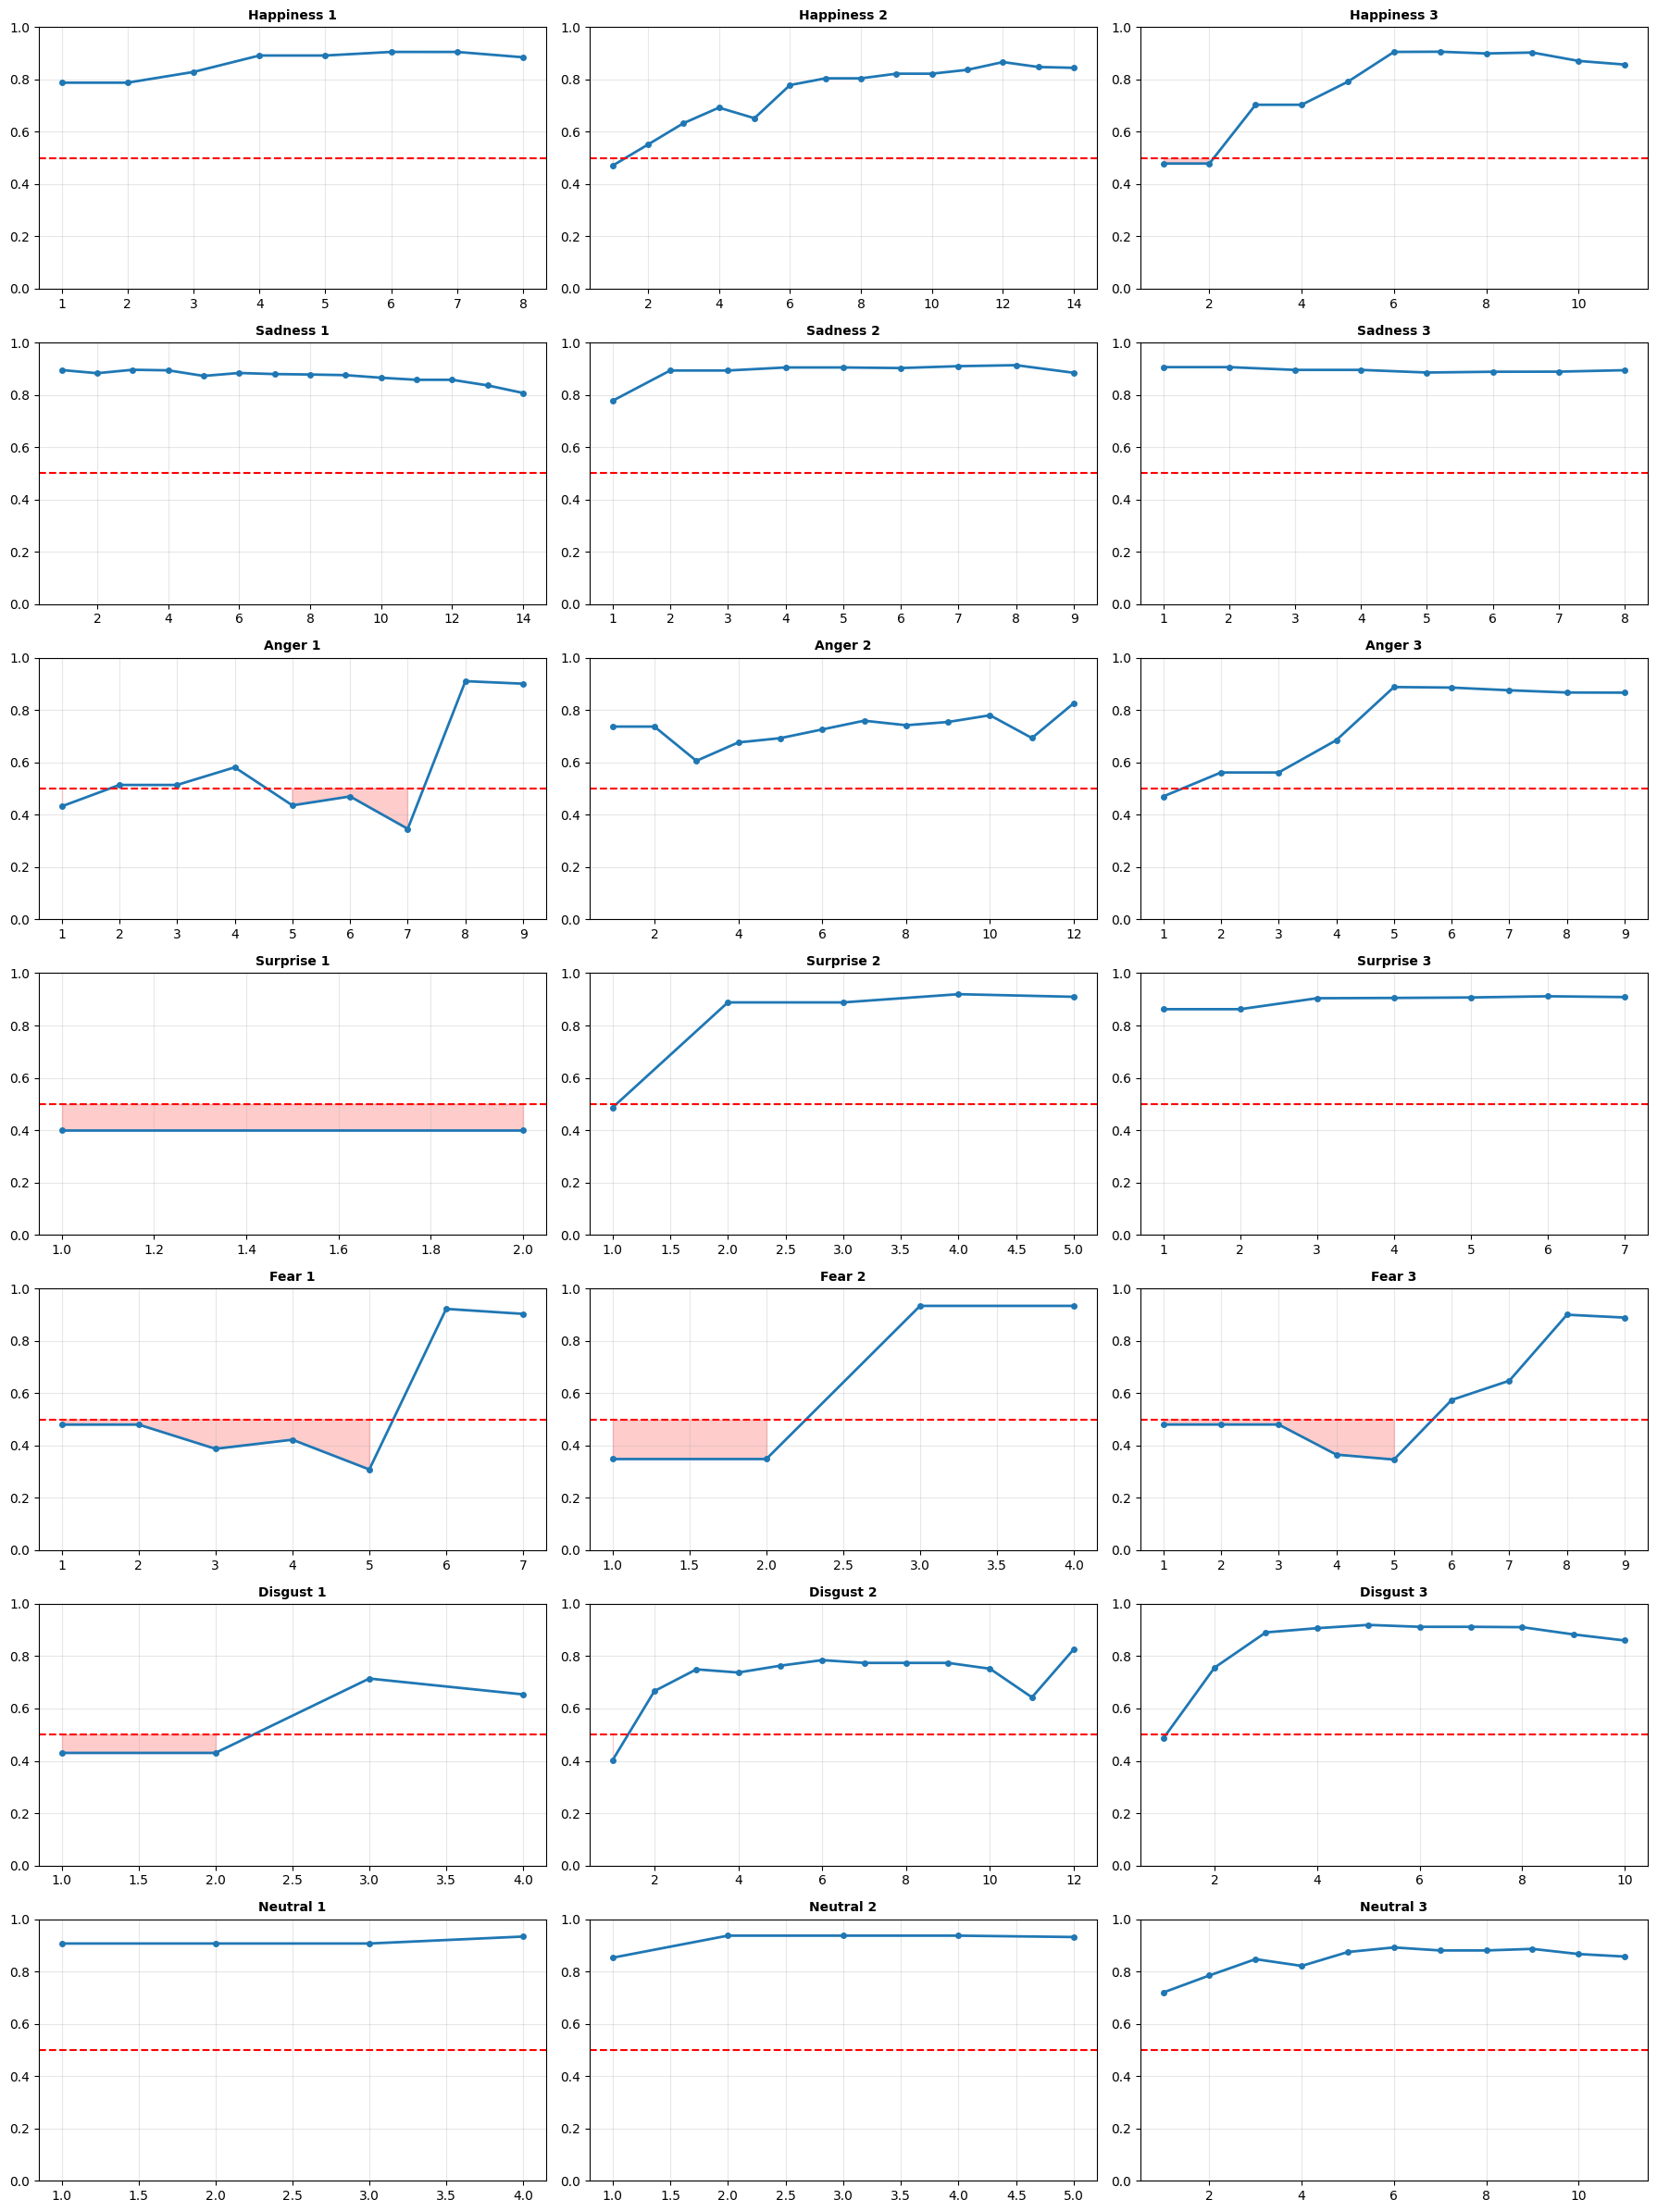

In [43]:
import os
os.makedirs("part3_graphs", exist_ok=True)
print(f"Starting {len(all_sentences)} sentences\n")

fig, axes = plt.subplots(7, 3, figsize=(18, 24))
axes = axes.flatten()

for idx, (emotion, num, text) in enumerate(all_sentences):
    inputs = tokenizer(text, return_tensors='pt')
    relevance_scores = gradient_x_input(model, inputs)
    confidences = perturb_input_and_evaluate(model, tokenizer, text, relevance_scores, 'remove')
    
    num_removed = list(range(1, len(confidences) + 1))
    
    axes[idx].plot(num_removed, confidences, 'o-', linewidth=2, markersize=4)
    axes[idx].axhline(0.5, color='red', linestyle='--', linewidth=1.5)
    axes[idx].fill_between(num_removed, confidences, 0.5, 
                           where=[c < 0.5 for c in confidences], 
                           color='red', alpha=0.2)
    axes[idx].set_title(f"{emotion.capitalize()} {num}", fontsize=10, fontweight='bold')
    axes[idx].set_ylim(0, 1)
    axes[idx].grid(alpha=0.3)
    
    print(f"{emotion.upper()} {num}")

plt.tight_layout()
plt.savefig("part3_graphs/all_21_perturbation.png", dpi=300, bbox_inches='tight')
plt.show()

## Overall Conclusion

This XAI analysis revealed how our RoBERTa emotion classification model makes decisions. We used three different methods to understand the model's behavior.

**What we learned fromG radient x Input:**

The Gradient × Input method showed us which tokens influence predictions. But the results were noisy. The model focused on some emotion words like "delicious" and "best" for happiness, but also gave high relevance to random words that don't carry emotional meaning. The bar graphs helped us see this, but the patterns weren't always clear.

**What we learnt form  propagation:**

Conservative Propagation gave us cleaner explanations. The heatmaps made patterns more visible than the bar graphs. We could see at a glance which tokens mattered. The attention heatmap showed us that the model builds logical connections between related words. The relevance heatmaps showed us which words drive the final decision.mThe improved method confirmed what we suspected from Part 1. The model does pay attention to emotion words when they're present. But for many sentences in our dataset, clear emotion words aren't there. That's why the model often predicts neutral.

**What we learnt from Robustness with Input Perturbation**

The perturbation analysis showed us that the model has different levels of robustness for different emotions. Neutral predictions are very stable. The model stays confident even when we remove most of the tokens. Fear and surprise predictions are more fragile. Remove a few key words and the confidence drops. This tells us the model has learned strong patterns for identifying neutral text. But it's less certain about emotional categories, especially when the emotional signals are subtle.

In conclution Our model works, but it doesn't always agree with the dataset labels. Many sentences labeled as sadness, anger, or fear in the dataset get predicted as neutral by the model. The XAI analysis shows why. Those sentences don't have strong emotional token patterns. They're mostly factual statements without clear emotion words.mThis could mean two things. Either the dataset has labeling issues, or emotions in text are more subtle than just looking for emotion words. Human annotators might label something as sad based on context and implications. But the model only sees the literal words. The model performs best on clear cases. When a sentence has obvious emotion indicators like "delicious" or an exclamation mark, the model gets it right and shows high confidence. When a sentence is ambiguous, the model defaults to neutral, which is actually reasonable behavior.

**What this means for using the model:**

If you're using this model to classify emotions, you should know it's conservative. It will call many things neutral unless there are clear emotional signals. That's not necessarily wrong. It just means the model has high standards for what counts as an emotion. The XAI analysis was valuable because it showed us these patterns. Without it, we might have just looked at accuracy scores and missed that the model is heavily biased toward neutral predictions. Now we understand why that happens and can decide if it's acceptable for our use case.

**Future improvements:**

Based on this analysis, we could improve the model by retraining with clearer emotion examples. Or we could accept that the model is conservative and adjust how we use it. Either way, we now understand what it's doing and why.